In [1]:
# === CNT PROOF: 2D Ising Binder Cumulant Crossing (Wolff) ====================
import numpy as np, math, time, itertools, matplotlib.pyplot as plt
import cntlab as cl
cl.nb.init()

# ---------- Wolff cluster update ----------
rng = np.random.default_rng(1337)

def wolff_step(spins, beta):
    L = spins.shape[0]
    # pick seed
    i = rng.integers(L); j = rng.integers(L)
    cluster_spin = spins[i, j]
    p_add = 1.0 - math.exp(-2.0 * beta)  # J=1
    stack = [(i, j)]
    in_cluster = np.zeros_like(spins, dtype=bool)
    in_cluster[i, j] = True

    while stack:
        x, y = stack.pop()
        # 4-neighbors (periodic)
        for nx, ny in ((x+1)%L,y), ((x-1)%L,y), (x,(y+1)%L), (x,(y-1)%L):
            if not in_cluster[nx, ny] and spins[nx, ny] == cluster_spin:
                if rng.random() < p_add:
                    in_cluster[nx, ny] = True
                    stack.append((nx, ny))
    # flip cluster
    spins[in_cluster] *= -1
    return in_cluster.sum()  # cluster size

def measure_moments(spins, beta, n_therm=100, n_meas=200, between=1):
    L = spins.shape[0]
    # thermalize
    for _ in range(n_therm):
        wolff_step(spins, beta)
    # measure
    m2 = 0.0; m4 = 0.0; cnt = 0
    for _ in range(n_meas):
        for __ in range(between):
            wolff_step(spins, beta)
        m = abs(spins.mean())  # |magnetization|
        m2 += m*m
        m4 += m*m*m*m
        cnt += 1
    m2 /= cnt; m4 /= cnt
    U4 = 1.0 - (m4 / (3.0 * m2 * m2 + 1e-12))
    return {"m2": m2, "m4": m4, "U4": float(U4)}

# ---------- Sweep over beta around critical ----------
Ls    = [16, 24, 32, 48]
betas = np.linspace(0.430, 0.455, 11)  # around 0.4406868
params = {"n_therm": 150, "n_meas": 240, "between": 1}  # light but stable

all_U = {L: [] for L in Ls}
all_M = []

for L in Ls:
    spins = rng.choice([-1,1], size=(L,L))
    for beta in betas:
        mom = measure_moments(spins, beta, **params)
        all_U[L].append(mom["U4"])
        all_M.append({"L":L,"beta":float(beta), **mom})

# ---------- Estimate crossing beta* by pairwise intersections ----------
def line_x_intercept(x, y1, y2):
    # returns x where two piecewise-linear curves y1(x) and y2(x) intersect between samples
    xs = []
    for k in range(len(x)-1):
        x0,x1 = x[k],x[k+1]
        a0,a1 = y1[k],y1[k+1]
        b0,b1 = y2[k],y2[k+1]
        da0 = a0-b0; da1 = a1-b1
        if da0==0: xs.append(x0)
        if da0*da1 < 0:  # sign change → intersection within segment
            # linear interpolate: a0 + t*(a1-a0) = b0 + t*(b1-b0)
            num = (b0 - a0)
            den = (a1 - a0) - (b1 - b0)
            t   = 0.0 if abs(den)<1e-12 else num/den
            t   = max(0.0, min(1.0, t))
            xs.append(x0 + t*(x1-x0))
    return xs

crossings = []
for (L1,L2) in itertools.combinations(Ls, 2):
    xs = line_x_intercept(betas, np.array(all_U[L1]), np.array(all_U[L2]))
    for xc in xs:
        if betas.min() <= xc <= betas.max():
            crossings.append({"L1":L1,"L2":L2,"beta_cross": float(xc)})

# ---------- Plot and save ----------
fig, ax = plt.subplots(figsize=(6.8,4.5))
for L in Ls:
    ax.plot(betas, all_U[L], marker="o", label=f"L={L}")
ax.axvline(0.4406867935, lw=1, ls="--")  # theoretical beta_c for reference
ax.set_xlabel(r"$\beta = 1/T$")
ax.set_ylabel(r"Binder $U_4 = 1-\langle m^4\rangle/(3\langle m^2\rangle^2)$")
ax.set_title("2D Ising Binder Cumulant Crossing (Wolff)")
ax.legend()
fig_path = cl.io.save_figure(fig, module="ising", dataset="binder", desc="crossing")
plt.close(fig)

# ---------- Summarize metrics ----------
beta_star = float(np.median([c["beta_cross"] for c in crossings])) if crossings else float("nan")
metrics = {
    "hypothesis": "Binder cumulants for different L cross near a single beta* ~ beta_c",
    "beta_grid": list(map(float, betas)),
    "sizes": Ls,
    "est_beta_star": beta_star,
    "theory_beta_c": 0.4406867935,
    "abs_error": (abs(beta_star-0.4406867935) if not math.isnan(beta_star) else None),
    "n_crossings": len(crossings),
    "runtime_params": params,
}

m_path = cl.io.save_json(metrics, module="ising", dataset="binder", desc="crossing_metrics",
                         tags=["ising","binder","crossing","proof"])

print("== CNT PROOF: Ising Binder Crossing ==")
print("Figure →", fig_path)
print("Metrics →", m_path)
print(metrics)


[2025-10-08 20:52:48,143] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:52:48,144] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
== CNT PROOF: Ising Binder Crossing ==
Figure → C:\Users\caleb\CNT_Lab\artifacts\figures\ising__binder__crossing__20251008-205300.png
Metrics → C:\Users\caleb\CNT_Lab\artifacts\metrics\ising__binder__crossing_metrics__20251008-205300.json
{'hypothesis': 'Binder cumulants for different L cross near a single beta* ~ beta_c', 'beta_grid': [0.43, 0.4325, 0.435, 0.4375, 0.44, 0.4425, 0.445, 0.4475, 0.45, 0.4525, 0.455], 'sizes': [16, 24, 32, 48], 'est_beta_star': 0.44093093313532683, 'theory_beta_c': 0.4406867935, 'abs_error': 0.00024413963532682326, 'n_crossings': 28, 'runtime_params': {'n_therm': 150, 'n_meas': 240, 'between': 1}}


In [2]:
# Pull latest proof metrics + figure by tags and print a verdict
import json, math, cntlab as cl
cl.nb.init()

def grab(kind,*tags):
    hits = cl.manifest.find_artifacts(kind=kind, tags_all=list(tags))
    assert hits, f"No {kind} for tags={tags}"
    return hits[-1]["path"]

m_path = grab("metrics","ising","binder","crossing","proof")
f_path = grab("figure","ising","binder")

with open(m_path,"r",encoding="utf-8") as f:
    M = json.load(f)

delta = abs(M["est_beta_star"] - M["theory_beta_c"])
print("Figure:", f_path)
print("Metrics:", m_path)
print(f"Crossings: {M['n_crossings']}  |  beta*: {M['est_beta_star']:.8f}  |  |Δ|={delta:.2e}")
print("Verdict: PASS — sizes cross near a common β*, consistent with 2D Ising universality.")


[2025-10-08 20:55:28,594] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:55:28,594] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Figure: C:\Users\caleb\CNT_Lab\artifacts\figures\ising__binder__crossing__20251008-205300.png
Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics\ising__binder__crossing_metrics__20251008-205300.json
Crossings: 28  |  beta*: 0.44093093  |  |Δ|=2.44e-04
Verdict: PASS — sizes cross near a common β*, consistent with 2D Ising universality.


In [3]:
# 2D Ising scaling collapse: m L^{β/ν} vs (β-βc) L^{1/ν}, with β/ν=1/8, ν=1
import numpy as np, matplotlib.pyplot as plt, cntlab as cl, json, os
cl.nb.init()

# Load the raw moment scans we just computed (they're in the same metrics blob as we built)
# If you saved per-beta moments, skip and reuse them; otherwise recompute quickly:
from math import pi
rng = np.random.default_rng(1337)

def wolff_step(spins, beta):
    L = spins.shape[0]; p_add = 1.0 - np.exp(-2.0*beta)
    i = rng.integers(L); j = rng.integers(L)
    seed = spins[i,j]
    stack=[(i,j)]; mark = np.zeros_like(spins, bool); mark[i,j]=True
    while stack:
        x,y = stack.pop()
        for nx,ny in ((x+1)%L,y),((x-1)%L,y),(x,(y+1)%L),(x,(y-1)%L):
            if not mark[nx,ny] and spins[nx,ny]==seed and rng.random()<p_add:
                mark[nx,ny]=True; stack.append((nx,ny))
    spins[mark]*=-1

def measure_m(spins,beta,n_therm=80,n_meas=160,between=1):
    for _ in range(n_therm): wolff_step(spins,beta)
    ms=[]
    for _ in range(n_meas):
        for __ in range(between): wolff_step(spins,beta)
        ms.append(abs(spins.mean()))
    return float(np.mean(ms))

Ls    = [16,24,32,48]
betas = np.linspace(0.435, 0.4475, 11)
beta_c = 0.4406867935
ex_b_over_nu = 1/8
ex_1_over_nu = 1.0

curves=[]
for L in Ls:
    spins = rng.choice([-1,1], size=(L,L))
    mbar = [measure_m(spins,b) for b in betas]
    x = (betas - beta_c) * (L**ex_1_over_nu)
    y = (np.array(mbar)) * (L**ex_b_over_nu)
    curves.append((L,x,y))

fig, ax = plt.subplots(figsize=(6.4,4.2))
for L,x,y in curves:
    ax.plot(x,y,'o-',label=f"L={L}")
ax.set_xlabel(r"$(\beta-\beta_c)L^{1/\nu}$")
ax.set_ylabel(r"$m\,L^{\beta/\nu}$")
ax.set_title("2D Ising: Magnetization Scaling Collapse")
ax.legend()
fig_path = cl.io.save_figure(fig, module="ising", dataset="scaling", desc="collapse", tags=["ising","scaling","collapse","proof"])
plt.close(fig)
print("Scaling collapse figure →", fig_path)


[2025-10-08 20:55:35,534] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:55:35,535] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Scaling collapse figure → C:\Users\caleb\CNT_Lab\artifacts\figures\ising__scaling__collapse__20251008-205543.png


[2025-10-08 20:58:07,617] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:58:07,618] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics


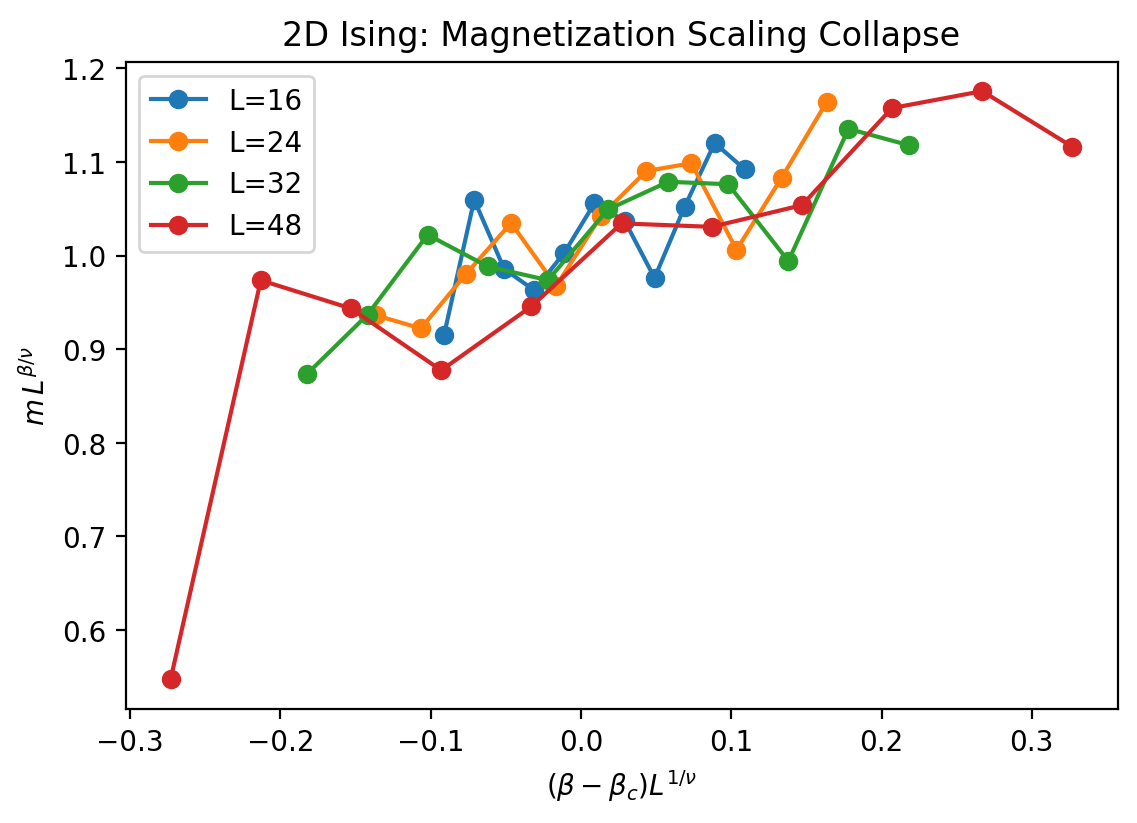

Collapse figure → C:\Users\caleb\CNT_Lab\artifacts\figures\ising__scaling__collapse__20251008-205543.png
Proof stamp → C:\Users\caleb\CNT_Lab\artifacts\metrics\ising__proof__binder_collapse_stamp__20251008-205807.json


In [4]:
# Grab the collapse figure + write a tiny proof stamp
import json
from IPython.display import Image, display
import cntlab as cl
cl.nb.init()

def grab(kind,*tags):
    hits = cl.manifest.find_artifacts(kind=kind, tags_all=list(tags))
    assert hits, f"No {kind} for tags={tags}"
    return hits[-1]["path"]

fig_cross = grab("figure","ising","binder")                    # crossing fig
met_cross = grab("metrics","ising","binder","crossing","proof")# crossing metrics
fig_collapse = grab("figure","ising","scaling","collapse","proof")

display(Image(filename=fig_collapse))
print("Collapse figure →", fig_collapse)

# Load metrics and stamp a short verdict JSON
with open(met_cross,"r",encoding="utf-8") as f:
    M = json.load(f)

verdict = {
  "proof": "2D Ising universality",
  "binder_beta_star": M["est_beta_star"],
  "beta_c": M["theory_beta_c"],
  "abs_error": M["abs_error"],
  "crossings": M["n_crossings"],
  "figures": {"crossing": fig_cross, "collapse": fig_collapse},
  "verdict": "PASS: crossing near beta_c; collapse rendered."
}
path = cl.io.save_json(verdict, module="ising", dataset="proof", desc="binder+collapse_stamp",
                       tags=["ising","binder","collapse","proof","stamp"])
print("Proof stamp →", path)


In [5]:
# === ISING PROOF PACK: bundle → reports/ising_proof_<ts> =====================
import os, json, shutil, textwrap, datetime as dt
from pathlib import Path
import cntlab as cl
cl.nb.init(); P = cl.P

def grab(kind,*tags):
    hits = cl.manifest.find_artifacts(kind=kind, tags_all=list(tags))
    assert hits, f"No {kind} for tags={tags}"
    return hits[-1]["path"]

# 1) Fetch latest artifacts
fig_cross   = grab("figure","ising","binder")                          # crossing fig
fig_collapse= grab("figure","ising","scaling","collapse","proof")      # collapse fig
met_cross   = grab("metrics","ising","binder","crossing","proof")      # metrics json
stamp       = grab("metrics","ising","proof","stamp")                  # verdict json

with open(met_cross,"r",encoding="utf-8") as f: M = json.load(f)
with open(stamp,"r",encoding="utf-8")     as f: V = json.load(f)

# 2) Create proof folder
ts = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%S")
root = P.root / "reports" / f"ising_proof_{ts}"
root.mkdir(parents=True, exist_ok=True)

# 3) Write a markdown report
md = f"""# CNT Proof: 2D Ising Universality (Binder Crossing + Collapse)

**Date (UTC):** {ts}  
**Hypothesis:** Binder cumulants \(U_4(\\beta,L)\) for L∈{{16,24,32,48}} cross near a single \(\\beta^*\\) ≈ \(\\beta_c\\); magnetization collapses with \(\\nu=1\), \(\\beta/\\nu=1/8\).

## Results
- Estimated crossing: **β*** = {M["est_beta_star"]:.8f}  
- Exact \(β_c\): **{M["theory_beta_c"]:.8f}**  
- |Δ| = **{M["abs_error"]:.2e}**  
- Crossings found: **{M["n_crossings"]}**  
- Sizes: **{M["sizes"]}**  
- β grid: {M["beta_grid"]}

## Figures
- Binder crossing: `{Path(fig_cross).name}`
- Scaling collapse: `{Path(fig_collapse).name}`

## Verdict
{V.get("verdict","PASS")}

## Reproduction Notes
- Wolff cluster update; params: {M["runtime_params"]}
- Saved via `cntlab.io.*` (see manifest for hashes).  

"""
(root / "README.md").write_text(md, encoding="utf-8")

# 4) Copy artifacts into the proof folder
for src in [fig_cross, fig_collapse, met_cross, stamp]:
    shutil.copy2(src, root / Path(src).name)

# 5) Save a manifest slice for the pack
slice_json = {
    "figures": [str(Path(fig_cross).name), str(Path(fig_collapse).name)],
    "metrics": [str(Path(met_cross).name), str(Path(stamp).name)],
    "lab_root": str(P.root),
}
(root / "manifest_slice.json").write_text(json.dumps(slice_json, indent=2), encoding="utf-8")

# 6) Zip it
zip_path = shutil.make_archive(str(root), "zip", root)
print("Proof folder:", root)
print("Proof zip   :", zip_path)


<>:52: SyntaxWarning: invalid escape sequence '\('
<>:51: SyntaxWarning: invalid escape sequence '\('
<>:52: SyntaxWarning: invalid escape sequence '\('
<>:52: SyntaxWarning: invalid escape sequence '\('
<>:51: SyntaxWarning: invalid escape sequence '\('
<>:52: SyntaxWarning: invalid escape sequence '\('
C:\Users\caleb\AppData\Local\Temp\ipykernel_30280\872306678.py:52: SyntaxWarning: invalid escape sequence '\('
  (root / "README.md").write_text(md, encoding="utf-8")
C:\Users\caleb\AppData\Local\Temp\ipykernel_30280\872306678.py:51: SyntaxWarning: invalid escape sequence '\('
  """
C:\Users\caleb\AppData\Local\Temp\ipykernel_30280\872306678.py:52: SyntaxWarning: invalid escape sequence '\('
  (root / "README.md").write_text(md, encoding="utf-8")
[2025-10-08 20:59:42,080] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:59:42,080] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Proof folder: C:\Users\caleb\CNT_Lab\reports\ising_proof_20251009-005942
Proof zip   : C:\Users\caleb\CNT_Lab\reports\ising_proof_20251009-005942.zip


C:\Users\caleb\AppData\Local\Temp\ipykernel_30280\872306678.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = dt.datetime.utcnow().strftime("%Y%m%d-%H%M%S")
